### Integral BL code for cylinder

In [1]:
include("bl_cyl.jl")

IBLm_cyl (generic function with 5 methods)

In [2]:
t, x, del, E = IBLm_cyl()


1.3700979159411864 1.7399590081420393 1.9714521618633019 10.50028184635716


(1.3700979159411864,[0.0,0.0483322,0.0966644,0.144997,0.193329,0.241661,0.289993,0.338325,0.386658,0.43499  …  2.7066,2.75494,2.80327,2.8516,2.89993,2.94826,2.9966,3.04493,3.09326,3.14159],[0.408933,0.430655,0.452378,0.459532,0.462749,0.46513,0.467608,0.470466,0.473794,0.477628  …  6.74586,6.91736,7.07603,7.22009,7.34811,7.45804,7.55114,7.67915,8.1618,8.64445],[0.446668,0.452646,0.458049,0.459784,0.460225,0.460233,0.460092,0.459888,0.459642,0.459356  …  -0.0829835,-0.0838713,-0.0846065,-0.0852432,-0.0859096,-0.0869929,-0.0895185,-0.095324,-0.104921,-0.113447])

In [4]:
using PyPlot

/Users/kiran/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


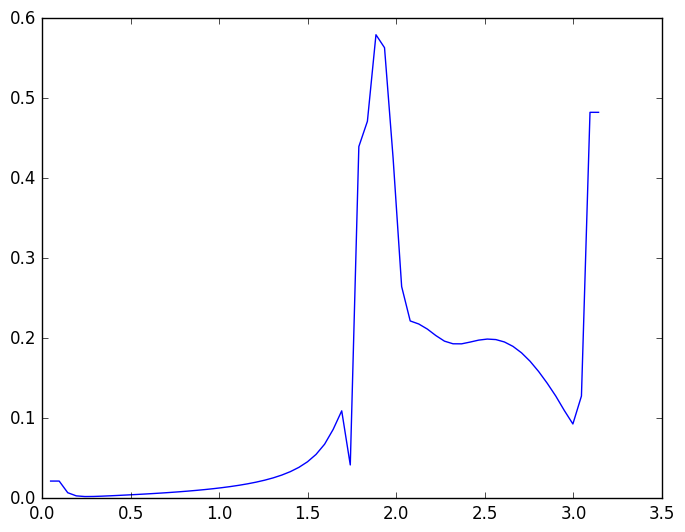

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31d0b2d10>

In [7]:
plot(x[2:end], diff(del))

In [29]:
### Express an airfoil as a Fourier series. 
using PyPlot
using ForwardDiff

function thick(x)
    num = 5
    b1 = 0.2969
    b2 = -0.1260
    b3 = -0.3516
    b4 = 0.2843
    b5 = -0.1015
    th = 5.*num*(b1*sqrt(x) + b2*x + b3*x^2 + b4*x^3 + b5*x^4)
end


thick (generic function with 2 methods)

In [62]:
# Consider a NACA 0012 airfoil. 
ncell = 64
num = 0.12
x = zeros(ncell + 2)
th = zeros(ncell + 2)
thdot = zeros(ncell + 2)

dx = 1./(ncell + 1.)
for ic = 1:ncell+2
    x[ic] = real(ic-1)*dx
end


for ic = 1:ncell+2
    th[ic] = thick(x[ic])
end 

for ic = 1:ncell+2
    thdot[ic] = ForwardDiff.derivative(thick,x[ic])
end


In [63]:
thdot

66-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [60]:
thdot[10] = ForwardDiff.derivative(thick,1.1)

-6.6588869656623

In [61]:
thdot

66-element Array{Float64,1}:
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    
 -6.65889
  0.0    
  0.0    
  0.0    
  ⋮      
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    
  0.0    